In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Embedding, GlobalMaxPooling1D, Dropout
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import scipy
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from util import plot_history
import re
import feature_builder
import eli5
from eli5.sklearn import PermutationImportance

c:\users\maxi\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\maxi\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Cargo datasets

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
kernel_size=1
strides=4

Armo features con el feature_builder

In [4]:
def prepare_for_cnn(df):
    processed = feature_builder.process_dataset(df)
    return processed.to_numpy().reshape(processed.shape[0], kernel_size, processed.shape[1])

In [5]:
X_train = prepare_for_cnn(train_df)
y_train = train_df['target'].values

Creo el modelo y corro la CNN

In [6]:
def create_model():
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=kernel_size, strides=strides, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Epoch 1/20
191/191 [==============================] - 1s 7ms/step - loss: 0.7243 - accuracy: 0.5893 - val_loss: 0.5676 - val_accuracy: 0.7262
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 0.5573 - accuracy: 0.7264 - val_loss: 0.4802 - val_accuracy: 0.7827
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 0.5265 - accuracy: 0.7483 - val_loss: 0.5229 - val_accuracy: 0.7538
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 0.4913 - accuracy: 0.7739 - val_loss: 0.4657 - val_accuracy: 0.7938
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 0.4766 - accuracy: 0.7862 - val_loss: 0.4351 - val_accuracy: 0.8011
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 0.4645 - accuracy: 0.7967 - val_loss: 0.4328 - val_accuracy: 0.8129
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 0.4618 - accuracy: 0.7966 - val_loss: 0.4392 - val_accuracy: 0.8122
Epoch 

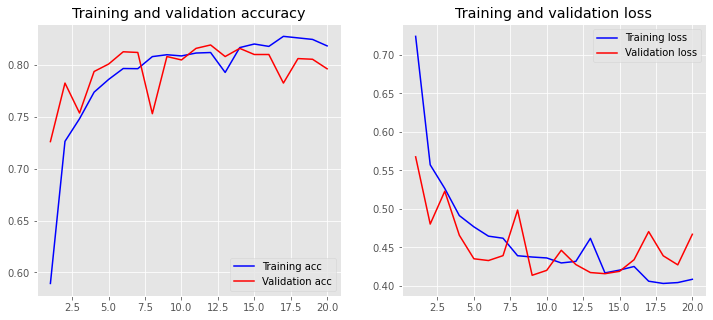

In [7]:
model = create_model()
history = model.fit(X_train, y_train, epochs=20, shuffle=True, validation_split=0.2)
plot_history(history)

In [23]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X_train.columns.tolist())

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002771CD44A48> does not.

Vemos cuales fallo

In [15]:
prediction = model.predict_classes(X_test)
df = pd.DataFrame({'text': test, 'target': y_test, 'prediction': [x[0] for x in prediction]})

NameError: name 'X_test' is not defined

In [ ]:
pd.set_option('display.max_rows', len(df))
pd.set_option('display.max_colwidth', None)
df[df['target'] != df['prediction']]

In [ ]:
df[df['target'] == df['prediction']]

Calculemos el test para kaggle

In [ ]:
ids = test_df['id']

final_test = prepare_for_cnn(test_df)
prediction = model.predict_classes(final_test)

final_df = pd.DataFrame({'target': [x[0] for x in prediction]}, index=ids)
final_df

In [ ]:
final_df['target'].value_counts()

In [ ]:
final_df.count()

In [ ]:
final_df.to_csv('cnn.csv')